We are tasked with predicting whether a given customer within the given dataset will churn. Churning is when a customer doesn't return to continue business and is a binary result so we'll choose logistic regression for our classification model. We must fit the model and check its accuracy. Lastly, we must generate a confusion matrix and ROC curve of the results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

In [ ]:
customers = pd.read_csv('GB886_IV_15_TelCoChurn.csv')

In [ ]:
customers.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#generate dummy variables but first categorize variables
customers=customers.drop('TotalCharges', axis=1)
#find numerical variables
customers['Churn']= customers['Churn'].replace({'No': 0, 'Yes': 1}).astype(int)
numerical=list(customers.select_dtypes(include=['int64','float64']).columns)
#find categorical variables
categorical = list(customers.select_dtypes(include=['object']).columns)
#separate numerical and categorical variables
customers_numerical = customers[numerical]
customers_categorical = customers[categorical]
print("Numerical columns:",numerical)
print("Categorical Columns:", categorical)

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']
Categorical Columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


/tmp/ipython-input-337300850.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customers['Churn']= customers['Churn'].replace({'No': 0, 'Yes': 1}).astype(int)


In [ ]:
#create dummies
dummies = pd.get_dummies(customers_categorical, drop_first=True)
print(dummies)

      gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0           False         True           False             False   
1            True        False           False              True   
2            True        False           False              True   
3            True        False           False             False   
4           False        False           False              True   
...           ...          ...             ...               ...   
7038         True         True            True              True   
7039        False         True            True              True   
7040        False         True            True             False   
7041         True         True           False              True   
7042         True        False           False              True   

      MultipleLines_No phone service  MultipleLines_Yes  \
0                               True              False   
1                              False              False   
2     

In [ ]:
# combine numerical and dummies
customers_cleaned = pd.concat([customers_numerical, dummies], axis=1)
#ensure numerical
customers_cleaned = customers_cleaned.astype(float)
#convert columns to a list to select variables to use for our model
customers_cleaned=customers_cleaned.drop('Churn', axis=1)
print(customers_cleaned.columns.tolist())

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [ ]:
#Run the logistic regression model
#convert churn to integer
y = customers['Churn']
X = customers_cleaned
logistic_mod = sm.Logit(y, sm.add_constant(X).astype(float))
logistic_mod = logistic_mod.fit(maxiter = 10000)
print(logistic_mod.summary())

Optimization terminated successfully.
         Current function value: 0.415374
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7019
Method:                           MLE   Df Model:                           23
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.2821
Time:                        02:08:07   Log-Likelihood:                -2925.5
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.4632      

In [ ]:
#check predictions
p_x = logistic_mod.predict()
y_hat = (p_x > 0.5)

In [ ]:
conf_mat = pd.crosstab(y, y_hat, rownames=['Actual Defaults'], colnames=['Predicted Defualts'])
# Add row and column sums
conf_mat.loc['Column_Total']= conf_mat.sum(numeric_only=True, axis=0)
conf_mat.loc[:,'Row_Total'] = conf_mat.sum(numeric_only=True, axis=1)
print(conf_mat)

Predicted Defualts  False  True  Row_Total
Actual Defaults                           
0                    4650   524       5174
1                     850  1019       1869
Column_Total         5500  1543       7043


In [ ]:
TPR = 1019 / 1869 # True-Positive Rate
TNR = 4650 / 5174 # True-Negative Rate
MCR = (524+850)/7043 # Miss Classification Rate
print('TPR =', TPR)
print('TNR =', TNR)
print('MCR =', MCR)

TPR = 0.545211342964152
TNR = 0.8987243911867028
MCR = 0.19508732074400115


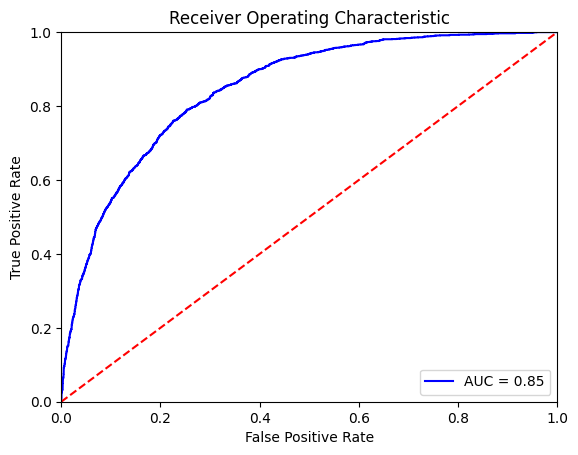

In [ ]:
fpr, tpr, threshold = roc_curve(y, p_x)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Summary:
The logistic model shows strong prediction performance with an area under the ROC curve of 0.85. The sensitivity metric is not as strong showing only 54.5% True Positive Rate. This suggests we should lower the probability threshold from 0.5 to capture more customers churning. We can see certain features such as fiber optic internet service and streaming are strong predictors of churn which can be used to adjust pricing. This model is useful for getting a generalized insight into which categories are highest predictors of churn.